<a href="https://colab.research.google.com/github/Jahan08/LogBB-ML-Model-with-interpretation/blob/main/LogBB_Classification_ANN_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Required Libraries

In [91]:
!pip install rdkit

In [92]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator



In [93]:
chembl_df = pd.read_csv("/content/All-LogBB-Categorical.csv")
chembl_df.head()

,Smiles,LogBB,Activity
0,CC1CCN(CC1)C(=O)c(c2)ccc3n(CC=C)c(c4c23)CCN(C4...,0,No
1,CC(=O)C,0,No
2,OCCCC,0,No
3,OCC,0,No
4,CO,0,No


In [94]:
external_df = pd.read_csv("/content/DAT.csv")
external_df.head()

,Smiles
0,CC1=CC(NCC(CC)C2=CC=CC=C2)=NC(C(C(C)=C3)=CN4C3...
1,CCC(C1=CC=CC=C1)CNC2=NC(C(C(C)=C3)=CN4C3=NC=C4...
2,CCC(CNc1nc(nc2c1CCCC2)-c1cn2ccnc2cc1C)c1ccccc1


In [95]:
compound_df = chembl_df.copy()

##Helper function for fingerprint generation

In [96]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

def smiles_to_fp(smiles, method="morgan10", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    # Handle cases where SMILES string is invalid
    if mol is None:
        print(f"Warning: Invalid SMILES string: {smiles}")
        return None  # or any default value you want to use for invalid SMILES

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan10":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=10, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

# Add column for fingerprint, handling potential None values
compound_df["fp"] = compound_df["Smiles"].apply(smiles_to_fp)
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

[17:42:20] WARNING: not removing hydrogen atom without neighbors
[17:42:20] WARNING: not removing hydrogen atom without neighbors
[17:42:20] WARNING: not removing hydrogen atom without neighbors
[17:42:20] WARNING: not removing hydrogen atom without neighbors
[17:42:21] WARNING: not removing hydrogen atom without neighbors
[17:42:22] WARNING: not removing hydrogen atom without neighbors
[17:42:22] WARNING: not removing hydrogen atom without neighbors


,Smiles,LogBB,Activity,fp
0,CC1CCN(CC1)C(=O)c(c2)ccc3n(CC=C)c(c4c23)CCN(C4...,0,No,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,CC(=O)C,0,No,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,OCCCC,0,No,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [97]:
external_compound_df = external_df.copy()

In [98]:
# Add column for fingerprint
external_compound_df["fp"] = external_compound_df["Smiles"].apply(smiles_to_fp)
external_compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,Smiles,fp
0,CC1=CC(NCC(CC)C2=CC=CC=C2)=NC(C(C(C)=C3)=CN4C3...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCC(C1=CC=CC=C1)CNC2=NC(C(C(C)=C3)=CN4C3=NC=C4...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCC(CNc1nc(nc2c1CCCC2)-c1cn2ccnc2cc1C)c1ccccc1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [99]:
# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22

###Preprocessing: Split the data

In [100]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.LogBB.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 2722
Test data size: 681


##Neural network classifier


In [101]:
# Deep Neural network specific libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

In [102]:
def neural_network_model(hidden1, hidden2, hidden3, hidden4, hidden5, hidden6):


    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="sigmoid", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="sigmoid", name="layer2"))
    # Third hidden layer
    model.add(Dense(hidden3, activation="sigmoid", name="layer3"))
    # Forth hidden layer
    model.add(Dense(hidden4, activation="sigmoid", name="layer4"))
    # Forth hidden layer
    model.add(Dense(hidden5, activation="sigmoid", name="layer5"))
    # Forth hidden layer
    model.add(Dense(hidden6, activation="sigmoid", name="layer6"))

    # Output layer
    model.add(Dense(1, activation="sigmoid", name="layer7"))

    # Compile model
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [103]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 256
layer2_size = 128
layer3_size = 64
layer4_size = 32
layer5_size = 16
layer6_size = 8

In [104]:
# Plot
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt


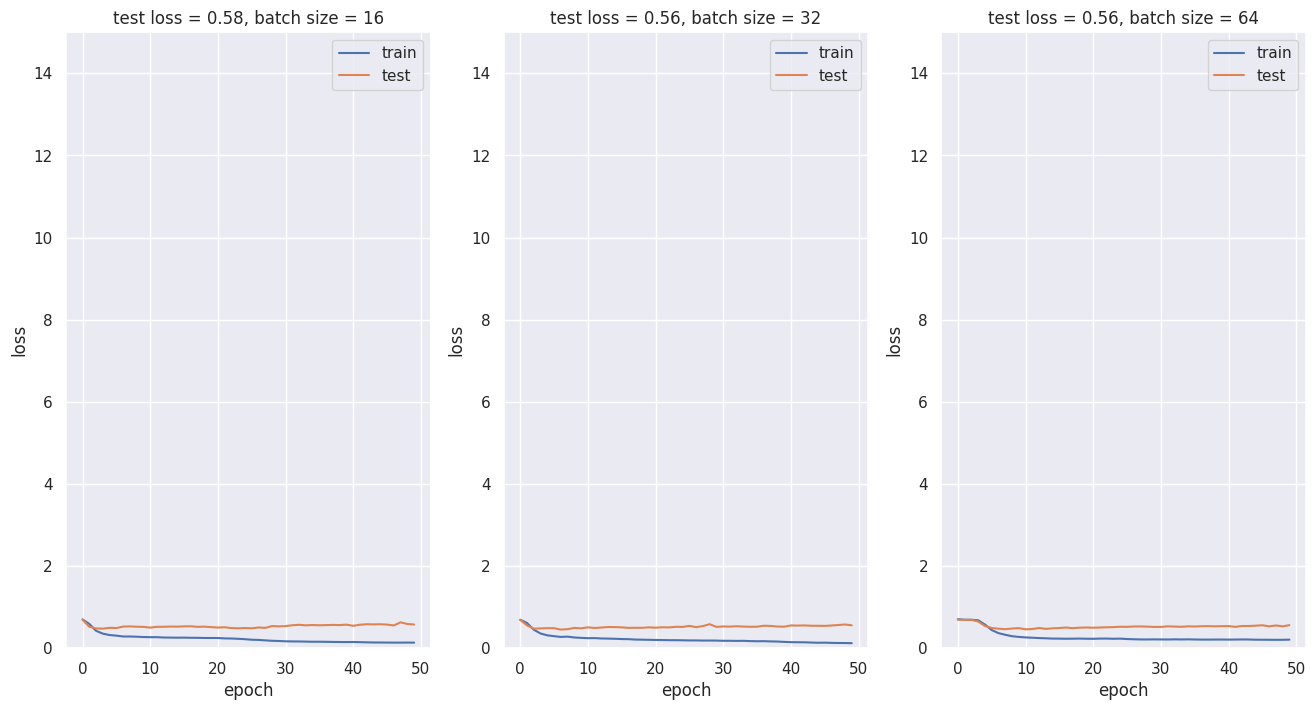

In [105]:
!pip install numpy
import numpy as np

fig = plt.figure(figsize=(16,8))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size, layer3_size, layer4_size, layer5_size, layer6_size)

    # Convert static_train_x to a NumPy array with dtype float32
    static_train_x = np.array(static_train_x, dtype=np.float32)

    # Convert static_train_y to a NumPy array
    static_train_y = np.array(static_train_y)

    # Convert static_test_x to a NumPy array with dtype float32
    static_test_x = np.array(static_test_x, dtype=np.float32)

    # Convert static_test_y to a NumPy array
    static_test_y = np.array(static_test_y)

    # Fit model on x_train, y_train data
    history = model.fit(
        static_train_x,
        static_train_y,
        batch_size=batch,
        validation_data=(static_test_x, static_test_y),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )

In [106]:
# Save the trained model
filepath = "/content/best_weights.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Convert static_train_x to a NumPy array with dtype float32
static_train_x = np.array(static_train_x, dtype=np.float32)

# Convert static_train_y to a NumPy array
static_train_y = np.array(static_train_y)

# Convert static_test_x to a NumPy array with dtype float32
static_test_x = np.array(static_test_x, dtype=np.float32)

# Convert static_test_y to a NumPy array
static_test_y = np.array(static_test_y)

# Fit the model
model.fit(
    static_train_x,
    static_train_y,
    epochs=nb_epoch,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=0,
)

###Helper function to calculate model performance.

In [107]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    #test_prob = ml_model.predict_proba(test_x)[:, 1]

     # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Convert predictions to binary values based on a threshold (e.g., 0.5)
    test_pred = (test_pred > 0.5).astype(int)

    test_prob = test_pred.flatten()

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [108]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Convert train_x to a NumPy array with dtype float32
    train_x = np.array(train_x, dtype=np.float32)

    # Convert train_y to a NumPy array
    train_y = np.array(train_y)

    # Convert test_x to a NumPy array with dtype float32
    test_x = np.array(test_x, dtype=np.float32)

    # Convert test_y to a NumPy array
    test_y = np.array(test_y)

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [109]:
# Fit model on single split
performance_measures = model_training_and_validation(model, "ANN", splits)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1341
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Accuracy: 0.83
Sensitivity: 0.90
Specificity: 0.75
AUC: 0.82


In [110]:
external_x_new = np.array(external_x, dtype=np.float32)

In [111]:
external_ANN_pred = model.predict(external_x_new)
external_ANN_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[0.94801503],
       [0.94819427],
       [0.6088533 ]], dtype=float32)

**Our model show very good values for all measured values (see AUCs) and thus seem to be predictive.**

###Cross-validation
Next, we will perform cross-validation experimentANN model. Therefore, we define a helper function for machine learning model training and validation in a cross-validation loop.

In [112]:
!pip install keras
import keras

def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):

        # Keras models can be cloned using the keras.models.clone_model function
        fold_model = keras.models.clone_model(ml_model)

        # Compile the model
        # You will likely need to customize these based on your model and data
        fold_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].LogBB.tolist()

        # Convert train_x to a NumPy array with dtype float32
        train_x = np.array(train_x, dtype=np.float32)

        # Convert train_y to a NumPy array
        train_y = np.array(train_y)


        #fold_model = SVC() # this line seems to be redundant
        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].LogBB.tolist()

        # Convert test_x to a NumPy array with dtype float32
        test_x = np.array(test_x, dtype=np.float32)

        # Convert test_y to a NumPy array
        test_y = np.array(test_y)

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

In [113]:
crossvalidation(model, compound_df, n_folds=5)

86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.4971 - loss: 0.7546
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5103 - loss: 0.7364
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4917 - loss: 0.7364
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4969 - loss: 0.6943
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4794 - loss: 0.6942
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean accuracy: 0.58 	and std : 0.11 
Mean sensitivity: 0.68 	and std : 0.41 
Mean specificity: 0.50 	and std : 0.44 
Mean AUC: 0.59 	and std : 0.11 
Time taken : 40.99s

